In [1]:
SEED = 0
cores = 8

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std
import matplotlib.pyplot as plt
from scipy import stats
from xgboost import plot_importance

In [2]:
df_train=pd.read_csv("~/proj_ua/data/ua_full.v1.csv")
df = df_train[df_train['from']=="cha"]
df2 = df.query('age>=18 & 60<=eGFR_ckd<90')

X = df2[["age","male","he_uph", "he_unitr", "he_usg", "he_upro", "he_uglu", "he_uket", "he_ubil", "he_ubld", "he_uro"]]
y = df2["eGFR_ckd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

/home/danssa/anaconda3/envs/xgb_tpot/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#standardization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std_cols = X_train.columns[X_train.max() > 1].tolist()
scaled_X_train = X_train.copy()
features = scaled_X_train[std_cols]
features = scaler.fit_transform(features.values)
scaled_X_train[std_cols] = features

In [4]:
def evaluate_model(X, y, model):
    cv = RepeatedKFold(n_splits=5, n_repeats=7, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=cores)
    return scores

 # model : tpot ua reg eg6090.v1
    
model = XGBRegressor(colsample_bytree=0.6, gamma=0.8, learning_rate=0.3, 
                     max_depth=2, min_child_weight=18, n_estimators=500, 
                     nthread=6, objective="reg:squarederror", 
                     reg_alpha=0.75, reg_lambda=8, subsample=0.8, random_state=SEED).fit(scaled_X_train, y_train)
scores = evaluate_model(scaled_X_train, y_train, model)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: -6.371 (0.029)


In [5]:
#feature importance

df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()
feat_num = df_imp.shape[0]
print("total number of features =", feat_num)

total number of features = 11


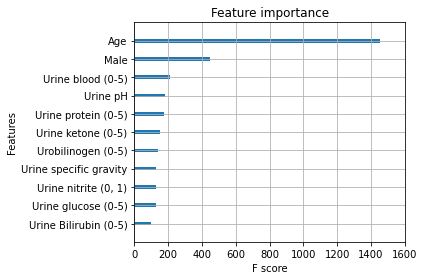

In [6]:
feat_names = model.get_booster().feature_names
df_feat_names = pd.DataFrame(feat_names, index=feat_names)
names = pd.read_csv('/home/danssa/KNHANES_eGFR/knhanes_urine_explain.csv', index_col ='var')
model.get_booster().feature_names = names.loc[df_feat_names.index,'name'].tolist()
g = plot_importance(model.get_booster(),importance_type='gain', show_values=False).get_figure()
plt.tight_layout()
plt.show()
#g.savefig('figtab/xgboost_importance.pdf', dpi=300, bbox_inches='tight')

In [7]:
model.get_booster().feature_names = feat_names #recover model feature names

In [8]:
std_df=X_test[std_cols].copy()
scaled_X_test = X_test.copy()
features = scaled_X_test[std_cols]
features = scaler.transform(features.values)
scaled_X_test[std_cols] = features

In [9]:
y_pred = model.predict(scaled_X_test)

from sklearn.metrics import mean_absolute_error
print('Mean absolute error = %.3f' % mean_absolute_error(y_test, y_pred))

Mean absolute error = 6.338


In [10]:
import statsmodels.api as sm

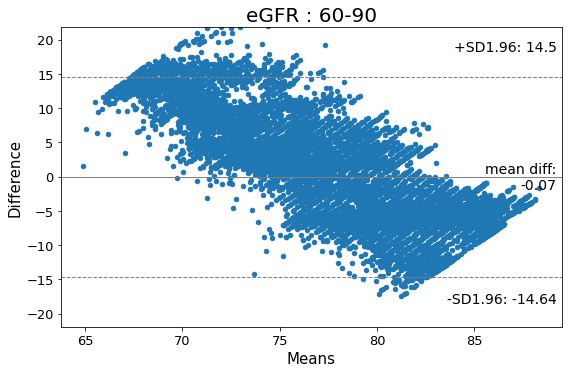

In [11]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred, y_test, ax = ax)
plt.title("eGFR : 60-90", fontsize=20)
plt.show()

[4.351618  4.3876095 4.2986226 ... 4.4132524 4.343245  4.4279947] [77.6039   80.44786  73.598366 ... 82.53748  76.95687  83.76326 ]


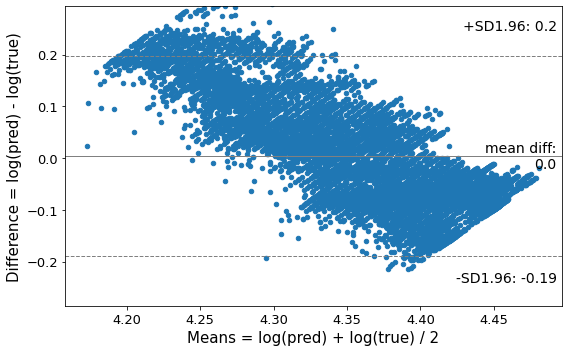

In [12]:
#log transformation bland-althman plot

import math 

y_pred_log = np.log(y_pred)
y_test_log = np.log(y_test)
print(y_pred_log, y_pred)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred_log, y_test_log, ax = ax)
plt.xlabel('Means = log(pred) + log(true) / 2')
plt.ylabel('Difference = log(pred) - log(true)')
plt.show()

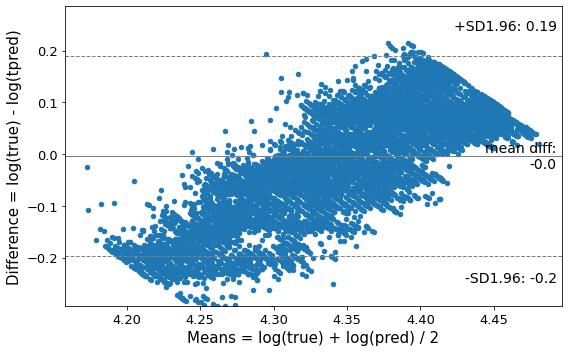

In [20]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_test_log, y_pred_log, ax = ax)
plt.xlabel('Means = log(true) + log(pred) / 2')
plt.ylabel('Difference = log(true) - log(tpred)')
plt.show()

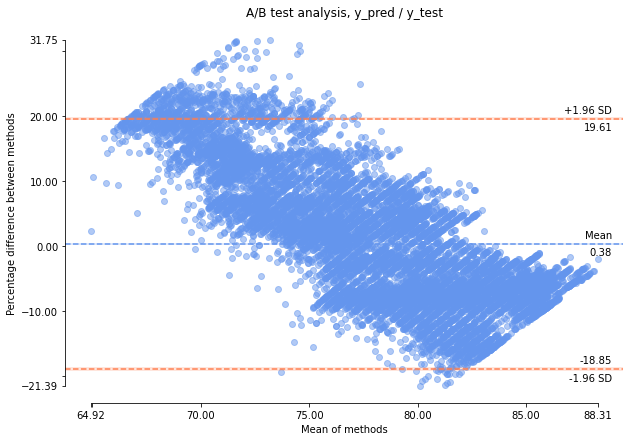

In [13]:
#bland altman A/B method
##https://towardsdatascience.com/why-how-to-use-the-bland-altman-plot-for-a-b-testing-python-code-78712d28c362

import pyCompare

pyCompare.blandAltman(y_pred, y_test, percentage=True, title='A/B test analysis, y_pred / y_test')

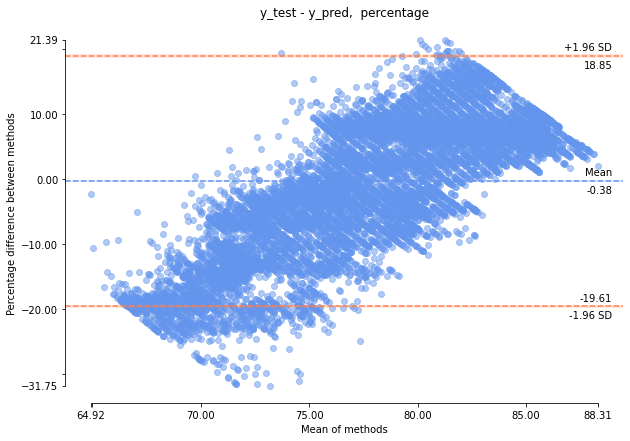

In [19]:
pyCompare.blandAltman(y_test, y_pred, percentage=True, title='y_test - y_pred,  percentage')

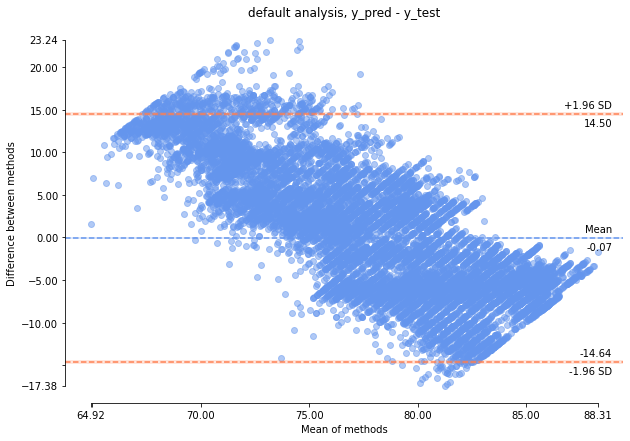

In [15]:
pyCompare.blandAltman(y_pred, y_test, title='default analysis, y_pred - y_test')

In [16]:
#plot in train prediction 

y_train_round = round(y_train)
y_train_pred = model.predict(scaled_X_train)

d_train = {'true_eGFR' : y_train, 'round_eGFR' : y_train_round, 'pred_eGFR' : y_train_pred, 'pred-true' : y_train_pred - y_train, 'ABS pred-true' : abs(y_train_pred-y_train)}
y_train_pd = pd.DataFrame(data=d_train)

y_train_gb = y_train_pd.groupby('round_eGFR').agg(['mean', 'std', 'count'])
y_train_gb.columns = ["_".join(x) for x in y_train_gb.columns.ravel()]
y_train_gb

,true_eGFR_mean,true_eGFR_std,true_eGFR_count,pred_eGFR_mean,pred_eGFR_std,pred_eGFR_count,pred-true_mean,pred-true_std,pred-true_count,ABS pred-true_mean,ABS pred-true_std,ABS pred-true_count
round_eGFR,,,,,,,,,,,,
60.0,60.213206,0.154596,376,75.177444,2.861390,376,14.964239,2.799663,376,14.964239,2.799663,376
61.0,61.024520,0.311786,889,75.323692,2.331840,889,14.299173,2.310115,889,14.299173,2.310115,889
62.0,62.029675,0.239853,774,76.033882,1.699437,774,14.004209,1.710070,774,14.004209,1.710070,774
63.0,62.935308,0.240085,826,76.203987,2.073144,826,13.268683,2.076707,826,13.268683,2.076707,826
64.0,63.968419,0.323635,1089,76.361115,2.383787,1089,12.392697,2.415194,1089,12.392697,2.415194,1089
65.0,65.040029,0.315460,1166,77.075272,2.528074,1166,12.035242,2.507181,1166,12.035242,2.507181,1166
66.0,66.069601,0.248109,1101,77.326645,2.638133,1101,11.257043,2.615653,1101,11.257043,2.615653,1101
67.0,67.023873,0.258480,1103,76.664680,2.750256,1103,9.640804,2.766841,1103,9.640804,2.766841,1103
68.0,67.985440,0.257622,1229,76.927361,2.782060,1229,8.941923,2.830736,1229,8.941923,2.830736,1229


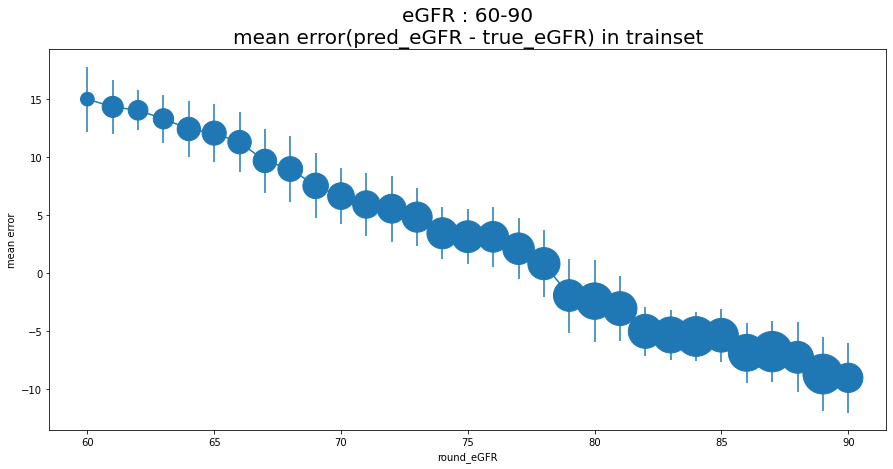

In [17]:
#plot errorbar

plt.rcParams['figure.figsize']=(15,7)
plt.errorbar(x=y_train_gb.index, y=y_train_gb['pred-true_mean'], yerr=y_train_gb['pred-true_std'])
plt.scatter(x=y_train_gb.index, y=y_train_gb['pred-true_mean'], s=y_train_gb['pred-true_count']*0.5)
plt.title('eGFR : 60-90\nmean error(pred_eGFR - true_eGFR) in trainset', fontsize=20)
plt.xlabel('round_eGFR')
plt.ylabel('mean error')
plt.show()